## Welcome to the pipeline of my zillow project

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.linear_model import LinearRegression

import aquire
import prep
import split_scale
import model
import features

from jupyterthemes import jtplot
jtplot.style()
import warnings
warnings.filterwarnings("ignore")

### Aquire

In [2]:
# define database to utilize and query to pull values
db = "zillow"
query = """
    SELECT 
        bathroomcnt as bathrooms,
        bedroomcnt as bedrooms, 
        calculatedfinishedsquarefeet as squarefeet,
        yearbuilt as year,
        fips as counties,
        taxvaluedollarcnt as taxvalue
        FROM properties_2017
        JOIN predictions_2017 USING (parcelid)
        WHERE transactiondate BETWEEN "2017-05-01" AND "2017-06-31"
            AND propertylandusetypeid in ("261")
            AND calculatedfinishedsquarefeet is not null
            AND NOT (finishedsquarefeet50 is not null AND finishedsquarefeet50 > calculatedfinishedsquarefeet)
            """

In [3]:
# pull data from mysql 
df = aquire.get_data(query, db)

In [4]:
# see the number of rows, column names, datatypes, and nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15006 entries, 0 to 15005
Data columns (total 6 columns):
bathrooms     15006 non-null float64
bedrooms      15006 non-null float64
squarefeet    15006 non-null float64
year          14987 non-null float64
counties      15006 non-null float64
taxvalue      15006 non-null float64
dtypes: float64(6)
memory usage: 703.5 KB


In [5]:
# see a sample of the df
df.head()

,bathrooms,bedrooms,squarefeet,year,counties,taxvalue
0,2.0,3.0,1458.0,1970.0,6037.0,136104.0
1,1.0,2.0,1421.0,1911.0,6037.0,35606.0
2,3.0,4.0,2541.0,2003.0,6059.0,880456.0
3,2.0,3.0,1650.0,1949.0,6037.0,614000.0
4,1.0,2.0,693.0,1921.0,6037.0,274237.0


In [6]:
# see the summary statistics of numeric rows without nulls
df.describe()

,bathrooms,bedrooms,squarefeet,year,counties,taxvalue
count,15006.000000,15006.000000,15006.000000,14987.000000,15006.000000,1.500600e+04
mean,2.325870,3.312941,1941.800880,1963.851671,6049.361589,5.412384e+05
std,1.021658,0.942691,1001.616927,23.326845,21.206492,7.307263e+05
min,0.000000,0.000000,300.000000,1878.000000,6037.000000,1.050400e+04
25%,2.000000,3.000000,1274.000000,1950.000000,6037.000000,1.985685e+05
50%,2.000000,3.000000,1678.500000,1961.000000,6037.000000,3.848830e+05
75%,3.000000,4.000000,2346.000000,1980.000000,6059.000000,6.446830e+05
max,11.000000,12.000000,15450.000000,2015.000000,6111.000000,2.385837e+07


### Prep

In [7]:
# why values were selected
data_dict = {
    "bathroomcnt":"selected bathroomcnt because calculatedbathnbr was always equal to bathroomcnt and they had some nulls", 
    "bedroomcnt":"this was the only bedroom value",
    "calculatedfinishedsquarefeet":"calculatedsqft had the least nulls. "
                                    "finishedsquarefeet6/12/13 all equaled calculated, so they were ignorable. "
                                    "for all finishedsquarefeet50 that were less than calculated, "
                                    "those values equaled the completedfirstfloor, therefore ignored. "
                                    "for all finishedsquarefeet50 that were greater than calculated, "
                                    "there were only six, and the anomaly was unknown, so they were removed",
    "yearbuilt":"tax values varied by year",
    "fips":"represented counties and tax values varied by county",
    "taxvaluedollarcnt":"this was the only assessed property tax value data"
}

In [8]:
# remove rows where there are no bathroms or bedrooms & drop nulls & change counties and years to categories
df = prep.clean_zillow(df)

In [9]:
# see that null rows were removed and categories were updated
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14968 entries, 0 to 15005
Data columns (total 6 columns):
bathrooms     14968 non-null float64
bedrooms      14968 non-null float64
squarefeet    14968 non-null float64
year          14968 non-null category
counties      14968 non-null category
taxvalue      14968 non-null float64
dtypes: category(2), float64(4)
memory usage: 620.0 KB


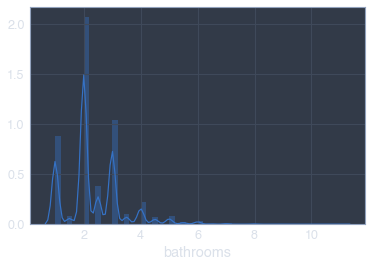

In [10]:
sns.distplot(df.bathrooms)
plt.show()

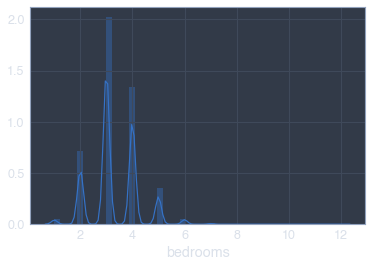

In [11]:
sns.distplot(df.bedrooms)
plt.show()

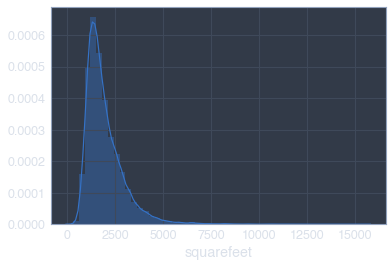

In [12]:
sns.distplot(df.squarefeet)
plt.show()

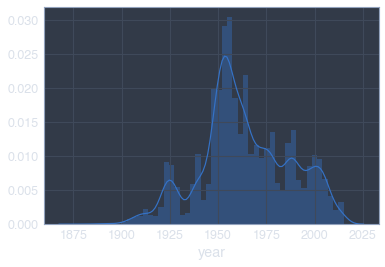

In [13]:
sns.distplot(df.year)
plt.show()

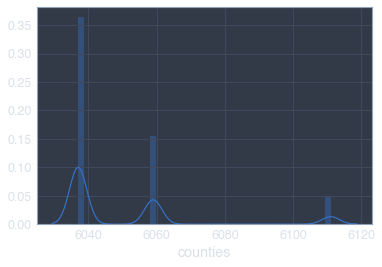

In [14]:
sns.distplot(df.counties)
plt.show()

In [15]:
# separate df by counties
df_6037 = df [df.counties == 6037.0]
df_6059 = df [df.counties == 6059.0]
df_6111 = df [df.counties == 6111.0]

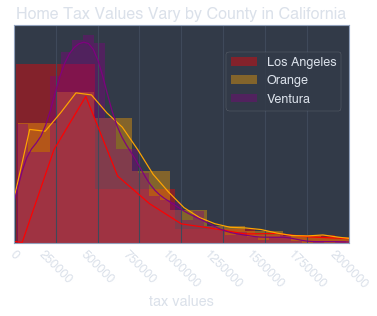

In [16]:
#plot tax distributions by county
plt.title("Home Tax Values Vary by County in California", fontsize=16)

sns.distplot(df_6037.taxvalue, label="Los Angeles", color="red")
sns.distplot(df_6059.taxvalue, label="Orange", color = "orange")
sns.distplot(df_6111.taxvalue, label="Ventura", color="purple")

plt.yticks([])
plt.figlegend(loc = (.6, .65))
plt.xlim(0, 2_000_000)
plt.xlabel('tax values')
plt.xticks(rotation=-45)
plt.show()


### Split & Scale

In [120]:
# split data into train and test
# a random state of 123 is set to the default in the split function
train, test = split_scale.split_my_data(df, .80)

# break train and test into an X (features) and y (target) dataframe
X_train = train.drop(columns="taxvalue")
X_test = test.drop(columns="taxvalue")
y_train = train[["taxvalue"]]
y_test = test[["taxvalue"]]

# scale the X data using the standard scaler
X_train_scaled, X_test_scaled, scaler = split_scale.standard_scaler(X_train, X_test)

### Explore

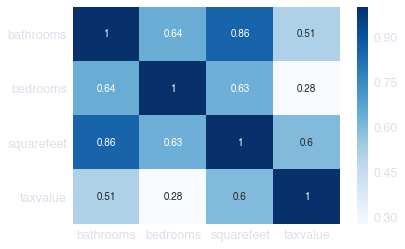

In [74]:
# show correlation of variables
sns.heatmap(train.corr(), cmap='Blues', annot=True)
plt.show()

In [75]:
# Run a t-test to compare counties to each other
t1, p1 = stats.ttest_ind(df_6037.taxvalue, df_6059.taxvalue)
t2, p2 = stats.ttest_ind(df_6059.taxvalue, df_6111.taxvalue)
t3, p3 = stats.ttest_ind(df_6037.taxvalue, df_6111.taxvalue)
print(f't-score: {t1:.2f}, p-value: {p1:.3f}')
print(f't-score: {t2:.2f}, p-value: {p2:.3f}')
print(f't-score: {t3:.2f}, p-value: {p3:.3f}')

t-score: -7.23, p-value: 0.000
t-score: 6.45, p-value: 0.000
t-score: 0.60, p-value: 0.550


> H0 = there is no difference between county6037 and county6059
- The p-value is zero, therefore, the null hypothesis is rejected

> H0 = there is no difference between county6059 and county6111
- The p-value is zero, therefore, the null hypothesis is rejected

> H0 = there is no difference between county6037 and county6111
- The p-value is greater than 0.05, therefore, the null hypothesis fails to be rejected

In [76]:
# Run a correlation test between bathrooms and squarefeet
stats.pearsonr(df.bathrooms, df.squarefeet)

(0.8557025856896057, 0.0)

> H0 = there is no correlation between bathrooms and squarefeet
- The p-value is zero, therefore, the null hypothesis is rejected

### Feature Selection

In [77]:
# run various optimal feature selections to determine best features
features.select_kbest_freg(X_train_scaled, y_train, 3)

['bathrooms', 'bedrooms', 'squarefeet']

(bathrooms      99093.746378
 bedrooms     -133107.724496
 squarefeet    504757.167288
 year         -100244.426940
 counties       -4803.943020
 dtype: float64, <matplotlib.axes._subplots.AxesSubplot at 0x1c1cd751d0>)

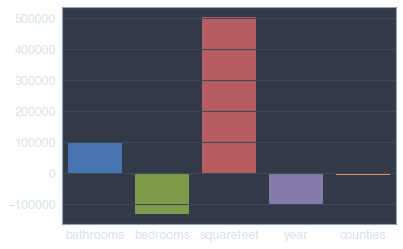

In [78]:
features.lasso_cv_coef(X_train_scaled, y_train)

In [79]:
features.recursive_feature_elimination(X_train_scaled, y_train)

Index(['bathrooms', 'bedrooms', 'squarefeet', 'year', 'counties'], dtype='object')

In [80]:
features.ols_backware_elimination(X_train_scaled, y_train)

['bathrooms', 'bedrooms', 'squarefeet', 'year']

In [81]:
# used the select_kbest_features & apply to X_train
optimal_features = features.ols_backware_elimination(X_train_scaled, y_train)
X_train_optimal = features.df_with_optimal_features(X_train_scaled, optimal_features)

### Modeling & Evaluation

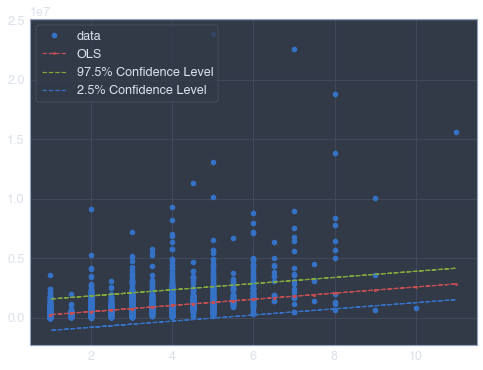

In [82]:
#plot the bathroom residuals
model.plot_regression(X_train.bathrooms,y_train)

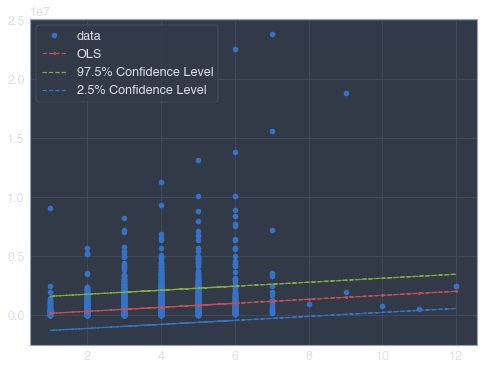

In [87]:
#plot the bedroom residuals
model.plot_regression(X_train.bedrooms,y_train)

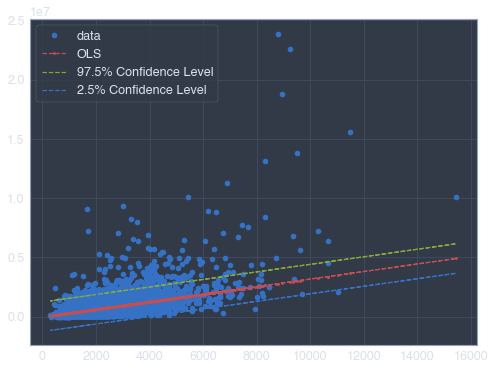

In [88]:
#plot the sqaurefeet residuals
model.plot_regression(X_train.squarefeet,y_train)

In [93]:
# compute the baseline, the mean of y 
baseline = model.compute_baseline(y_train)

In [94]:
# calculate the SSE, MSE, RMSE, r2 for the baseline
SSE, MSE, RMSE, r2 = model.evaluate(predictions.actuals, baseline)
print(f'SSE  = {SSE:.0f}')
print(f'MSE  = {MSE:.0f}')
print(f'RMSE = {RMSE:.0f}')
print(f'r^2  = {r2:.2f}')

SSE  = 299422485003
MSE  = 3585284835425561
RMSE = 547195
r^2  = -509686891976.39


#### Model 1 - bathrooms, bedrooms, squarefeet

In [115]:
# create df to model
X_train1 = X_train_scaled[["bathrooms","bedrooms","squarefeet"]]
# create a new df called predictions, fit and predict based on X_train
predictions1 = y_train.rename(columns = {"taxvalue":"actuals"})
predictions1 = model.linear_model(X_train1, y_train, predictions1)
# calculate the SSE, MSE, RMSE, r2 for the prediction
SSE, MSE, RMSE, r2 = model.evaluate(predictions1.actuals, predictions1.lm)
print(f'SSE  = {SSE:.0f}')
print(f'MSE  = {MSE:.0f}')
print(f'RMSE = {RMSE:.0f}')
print(f'r^2  = {r2:.3f}')

SSE  = 364961334367
MSE  = 4370047017713520
RMSE = 604120
r^2  = 0.379


#### Model 2 - squarefeet

In [117]:
# create df to model
X_train2 = X_train_scaled[["squarefeet"]]
# create a new df called predictions, fit and predict based on X_train
predictions2 = y_train.rename(columns = {"taxvalue":"actuals"})
predictions2 = model.linear_model(X_train2, y_train, predictions2)
# calculate the SSE, MSE, RMSE, r2 for the prediction
SSE, MSE, RMSE, r2 = model.evaluate(predictions2.actuals, predictions2.lm)
print(f'SSE  = {SSE:.0f}')
print(f'MSE  = {MSE:.0f}')
print(f'RMSE = {RMSE:.0f}')
print(f'r^2  = {r2:.3f}')

SSE  = 376335804214
MSE  = 4506244919653299
RMSE = 613462
r^2  = 0.359


#### Model 3 - bedrooms, bathrooms, squarefeet, year

In [119]:
# create df to model
X_train3 = X_train_scaled[["bathrooms","bedrooms","squarefeet","year"]]
# create a new df called predictions, fit and predict based on X_train
predictions3 = y_train.rename(columns = {"taxvalue":"actuals"})
predictions3 = model.linear_model(X_train3, y_train, predictions3)
# calculate the SSE, MSE, RMSE, r2 for the prediction
SSE, MSE, RMSE, r2 = model.evaluate(predictions3.actuals, predictions3.lm)
print(f'SSE  = {SSE:.0f}')
print(f'MSE  = {MSE:.0f}')
print(f'RMSE = {RMSE:.0f}')
print(f'r^2  = {r2:.3f}')

SSE  = 357316238675
MSE  = 4278504641894824
RMSE = 597759
r^2  = 0.392


#### Model 4a - model by county 6037, use features bathroom, bedroom, squarefeet

In [178]:
# split data into train and test
# a random state of 123 is set to the default in the spit function
train, test = split_scale.split_my_data(df_6037, .80)

# break train and test into an X (features) and y (target) dataframe
X_train = train.drop(columns="taxvalue")
X_test = test.drop(columns="taxvalue")
y_train = train[["taxvalue"]]
y_test4a = test[["taxvalue"]]

# scale the X data using the standard scaler
X_train_scaled, X_test_scaled, scaler = split_scale.standard_scaler(X_train, X_test)

# save X_test
X_test4a = X_test_scaled

In [179]:
# compute the baseline, the mean of y 
baseline4a = model.compute_baseline(y_train)

# create df to model
X_train4a = X_train_scaled[["bathrooms","bedrooms","squarefeet"]]
# create a new df called predictions, fit and predict based on X_train
predictions4a = y_train.rename(columns = {"taxvalue":"actuals"})
predictions4a = model.linear_model(X_train4a, y_train, predictions4)
# calculate the SSE, MSE, RMSE, r2 for the prediction
SSE, MSE, RMSE, r2 = model.evaluate(predictions4a.actuals, predictions4a.lm)
print(f'SSE  = {SSE:.0f}')
print(f'MSE  = {MSE:.0f}')
print(f'RMSE = {RMSE:.0f}')
print(f'r^2  = {r2:.3f}')

SSE  = 343246949295
MSE  = 2636136570587681
RMSE = 585873
r^2  = 0.407


#### Model 4b - model by county 6059, use features bathroom, bedroom, squarefeet

In [180]:
# split data into train and test
# a random state of 123 is set to the default in the spit function
train, test = split_scale.split_my_data(df_6059, .80)

# break train and test into an X (features) and y (target) dataframe
X_train = train.drop(columns="taxvalue")
X_test = test.drop(columns="taxvalue")
y_train = train[["taxvalue"]]
y_test4b = test[["taxvalue"]]

# scale the X data using the standard scaler
X_train_scaled, X_test_scaled, scaler = split_scale.standard_scaler(X_train, X_test)

# save X_test
X_test4b = X_test_scaled

In [181]:
# compute the baseline, the mean of y 
baseline4b = model.compute_baseline(y_train)

# create df to model
X_train4b = X_train_scaled[["bathrooms","bedrooms","squarefeet"]]

# create a new df called predictions, fit and predict based on X_train
predictions4b = y_train.rename(columns = {"taxvalue":"actuals"})
predictions4b = model.linear_model(X_train4b, y_train, predictions4b)

# calculate the SSE, MSE, RMSE, r2 for the prediction
SSE, MSE, RMSE, r2 = model.evaluate(predictions4b.actuals, predictions4b.lm)
print(f'SSE  = {SSE:.0f}')
print(f'MSE  = {MSE:.0f}')
print(f'RMSE = {RMSE:.0f}')
print(f'r^2  = {r2:.3f}')

SSE  = 172485926853
MSE  = 564891410443485
RMSE = 415314
r^2  = 0.442


#### Model 4c - model by county 6111, use features bathroom, bedroom, squarefeet

In [197]:
# split data into train and test
# a random state of 123 is set to the default in the spit function
train, test = split_scale.split_my_data(df_6111, .80)

# break train and test into an X (features) and y (target) dataframe
X_train = train.drop(columns="taxvalue")
X_test = test.drop(columns="taxvalue")
y_train = train[["taxvalue"]]
y_test4c = test[["taxvalue"]]

# scale the X data using the standard scaler
X_train_scaled, X_test_scaled, scaler = split_scale.standard_scaler(X_train, X_test)

# save X_test
X_test4c = X_test_scaled

In [195]:
# compute the baseline, the mean of y 
baseline4c = model.compute_baseline(y_train)

# create df to model
X_train4c = X_train_scaled[["bathrooms","bedrooms","squarefeet"]]
# create a new df called predictions, fit and predict based on X_train
predictions4c = y_train.rename(columns = {"taxvalue":"actuals"})
predictions4c = model.linear_model(X_train4c, y_train, predictions4c)
# calculate the SSE, MSE, RMSE, r2 for the prediction
SSE, MSE, RMSE, r2 = model.evaluate(predictions4c.actuals, predictions4c.lm)
print(f'SSE  = {SSE:.0f}')
print(f'MSE  = {MSE:.0f}')
print(f'RMSE = {RMSE:.0f}')
print(f'r^2  = {r2:.3f}')

SSE  = 49382358014
MSE  = 50271240458628
RMSE = 222221
r^2  = 0.583


#### It is evident that the model performs best when the data is split by county

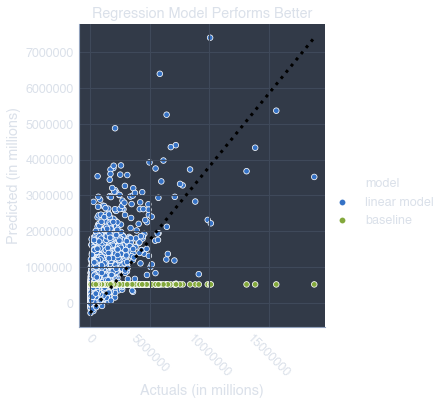

In [184]:
# plot the linear regression model versus the baseline
model.plot_linear_model(predictions4a.actuals,predictions4a.lm, baseline4a)

plt.plot([predictions4a.actuals.min(),predictions4a.actuals.max()],[predictions4a.lm.min(),predictions4a.lm.max()], \
         c='black', ls=':', linewidth = 3)
plt.title('Regression Model Performs Better')
plt.ticklabel_format(style="plain")
plt.ylabel("Predicted (in millions)")
plt.xlabel("Actuals (in millions)")
plt.xticks(rotation=-45)
plt.show()


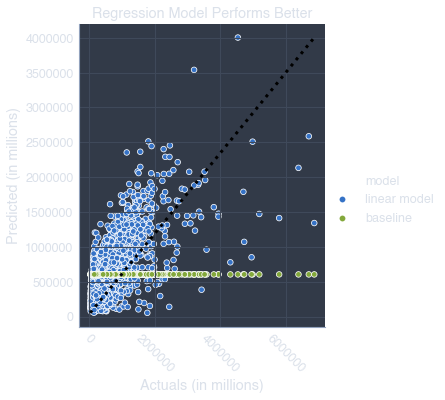

In [185]:
# plot the linear regression model versus the baseline
model.plot_linear_model(predictions4b.actuals,predictions4b.lm, baseline4b)

plt.plot([predictions4b.actuals.min(),predictions4b.actuals.max()],[predictions4b.lm.min(),predictions4b.lm.max()], \
         c='black', ls=':', linewidth = 3)
plt.title('Regression Model Performs Better')
plt.ticklabel_format(style="plain")
plt.ylabel("Predicted (in millions)")
plt.xlabel("Actuals (in millions)")
plt.xticks(rotation=-45)
plt.show()

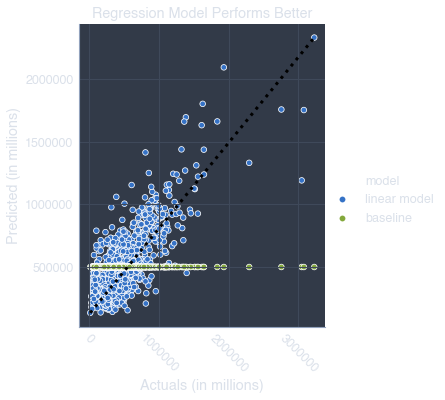

In [170]:
# plot the linear regression model versus the baseline
model.plot_linear_model(predictions4c.actuals,predictions4c.lm, baseline4c)

plt.plot([predictions4c.actuals.min(),predictions4c.actuals.max()],[predictions4c.lm.min(),predictions4c.lm.max()], \
         c='black', ls=':', linewidth = 3)
plt.title('Regression Model Performs Better')
plt.ticklabel_format(style="plain")
plt.ylabel("Predicted (in millions)")
plt.xlabel("Actuals (in millions)")
plt.xticks(rotation=-45)
plt.show()


### Test

#### Model 4a - model by county 6037, use features bathroom, bedroom, squarefeet

In [201]:
test_baseline = model.compute_baseline(y_test4a)
test_predictions = y_test4a.rename(columns = {"taxvalue":"actuals"})
test_predictions = model.linear_model(X_test4a, y_test4a, test_predictions)

SSE, MSE, RMSE, r2 = model.evaluate(test_predictions.actuals, test_predictions.lm)
print(f'SSE  = {SSE:.0f}')
print(f'MSE  = {MSE:.0f}')
print(f'RMSE = {RMSE:.0f}')
print(f'r^2  = {r2:.3f}')

SSE  = 639361598832
MSE  = 1228213631356901
RMSE = 799601
r^2  = 0.337


#### Model 4b - model by county 6059, use features bathroom, bedroom, squarefeet

In [202]:
test_baseline = model.compute_baseline(y_test4b)
test_predictions = y_test4b.rename(columns = {"taxvalue":"actuals"})
test_predictions = model.linear_model(X_test4b, y_test4b, test_predictions)

SSE, MSE, RMSE, r2 = model.evaluate(test_predictions.actuals, test_predictions.lm)
print(f'SSE  = {SSE:.0f}')
print(f'MSE  = {MSE:.0f}')
print(f'RMSE = {RMSE:.0f}')
print(f'r^2  = {r2:.3f}')

SSE  = 367395340649
MSE  = 300896783991173
RMSE = 606131
r^2  = 0.420


#### Model 4c - model by county 6111, use features bathroom, bedroom, squarefeet

In [203]:
test_baseline = model.compute_baseline(y_test4c)
test_predictions = y_test4c.rename(columns = {"taxvalue":"actuals"})
test_predictions = model.linear_model(X_test4c, y_test4c, test_predictions)

SSE, MSE, RMSE, r2 = model.evaluate(test_predictions.actuals, test_predictions.lm)
print(f'SSE  = {SSE:.0f}')
print(f'MSE  = {MSE:.0f}')
print(f'RMSE = {RMSE:.0f}')
print(f'r^2  = {r2:.3f}')

SSE  = 34424996715
MSE  = 8778374162258
RMSE = 185540
r^2  = 0.647
